# [GN-8]Hugging Face Custom Project

이번 프로젝트는 😊 Huggingface의 Pretrained 모델을 가져와서 Custom Dataset을 이용해 Finetuning을 진행하는 프로젝트이다.   
데이터셋은 Naver Review (nsmc)데이타셋이다.

### 데이타 훈련 전략   
#### 1) 1만 데이타    
Train DataSet이 10만개나 데이타라서 한번 (3 epoch) 훈련하는데도 7~10시간이 걸렸다. 
이대로 성능 튜닝을 위한 하이퍼 파라미터 조정을 수행 할 수 없어서  1/10 사이즈인 1만개 데이타로 줄여서 파라미터를 조정하고
가장 좋은 성능을 보이는 훈련전략을 도출했다. 

#### 2) 10만 데이타    
좋은 성능이 나오리라 기대하는 훈련전략으로 전체 데이타를 훈련했다. 
역시 시간이 많이 걸렸다. 

### 라이브러리 확인

In [5]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [6]:
import datasets
from datasets import load_dataset

In [7]:
val_ds = datasets.load_dataset('nsmc', split='train[:50000]')
train_ds = datasets.load_dataset('nsmc', split='train[50000:]')
test_ds = datasets.load_dataset('nsmc', split='test[:50000]')

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)
Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


🧐 Train, Val, Test set의 데이타를 분리해 주었다. 한번 load해서 나누는 방법이 있을 텐데, 찾지 못해 load dataset의 split을 써서 3번 썼다.

In [8]:
train_ds

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 100000
})

In [9]:
val_ds

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 50000
})

In [10]:
test_ds

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 50000
})

🧐 Train: 10만개 Val: 5만개 Test: 5만건 

In [11]:
cols = train_ds.column_names
for i in range(5):
    for col in cols:
        print(col, ":", train_ds[col][i])
    print('\n')

id : 8867980
document : 재미가 없으면 길게만들지도 마... 샬리즈테론 내내버럭하고 틴에이저퀸 스튜어트는 앞니만보이고 몰입감도 없고 토르는 내내 지저분해서 정도 안가는데 김보성느낌나고 애매한 캐릭터 윌리엄에 무의미한 전투씬들.. 억지로 끼워넣은 난장이들. 대체 뭘위해서?
label : 0


id : 7129770
document : 굿굿 아라의 마지막 뒷모습이 너무 기억에 나네요 사람은 백프로 드러난 잘못에만 진짜로 미안해해 ㅠㅠ
label : 1


id : 6310338
document : 스케일 대박... 1,2보다 훨씬 크네요 헬기씬이 아찔해서 10점
label : 1


id : 2745807
document : 소설이원작인가?이런소설은생각하면서 의미를부여하지만..영상으론 최악임...
label : 0


id : 5325844
document : 이영화가 유명한 감독의 영화라니 믿어지지 않네요
label : 0




- label 0 : 부정적 리뷰 
- label 1: 긍정적 리뷰

## STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [12]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

#model = AutoModel.from_pretrained("klue/bert-base")      
#tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-small")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-small")

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/260M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'cla

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

🧐 처음 시도는 klue/bert-base(156k)으로 model과 tokenizer선택했는데, 훈련시간이 너무 오래걸려서 11시간 예상.
파라미터가 작은 klue/roberta-small(2.53k)로 시도했다. 훈련시간은 7시간 내외로 예상치가 좀 줄었다.

## STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

In [13]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = True,
        )

for i in range(1):
    t = transform(train_ds[i])
    print(t)

{'input_ids': [0, 4697, 2116, 1415, 6076, 647, 2318, 2154, 2031, 13807, 1036, 18, 18, 18, 1252, 2059, 2228, 2201, 2570, 6404, 2264, 2823, 19521, 1821, 11264, 2190, 3416, 25932, 2259, 1388, 2209, 2154, 16555, 2088, 11306, 2434, 2119, 1415, 2088, 24321, 2259, 6404, 18234, 6396, 3681, 1378, 2116, 13964, 17264, 2047, 2922, 3040, 2075, 2088, 11548, 2470, 5690, 10954, 2170, 20514, 2470, 5635, 2410, 2031, 18, 18, 11057, 13646, 3475, 2073, 21075, 2052, 2031, 18, 4761, 1099, 2090, 6396, 35, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [14]:
hf_train_dataset = train_ds.map(transform, batched=True)
hf_val_dataset = val_ds.map(transform, batched=True)
hf_test_dataset = test_ds.map(transform, batched=True)



  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [15]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
import pandas as pd
import matplotlib.pyplot as plt
from transformers import EarlyStoppingCallback, TrainerCallback
output_dir = './transformers'


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
from datasets import load_metric
# KLUE 데이터셋에 대한 메트릭 로드
m_acc= load_metric('accuracy')
m_f1 = load_metric('f1')

def compute_metrics(pred):  


    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = m_acc.compute(predictions= preds, references=labels)['accuracy']
    f1 = m_f1.compute(predictions= preds, references=labels)['f1']
    return {
        'accuracy': acc,
        'f1': f1
    }


Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

### 3-1 Train - Base

In [13]:
# 하이퍼 파라미터 base
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 250,
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=250
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    #data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

#trainer.train()       
#history_base = pd.DataFrame(trainer.state.log_history)

In [14]:
#history_base.to_csv('history_base.csv')

🧐 기본 Base 모델을 위와 같이 잡았다. 

## STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

### 4-1  learning_rate (2e-5 -> 3e-5 ) 조정

In [15]:
# 하이퍼파라미터 base   learning_rate = 3e-5, 
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 250,
    learning_rate = 3e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=250
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    #data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

# trainer.train()        
# history_lr3 = pd.DataFrame(trainer.state.log_history)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [16]:
#history_lr3.to_csv('history_lr3.csv')

### 4-2 weight_decay 조정(0.01 -> 0.02)

In [17]:
# 하이퍼파라미터 base   weight_decay = 0.02,   
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 250,
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.02,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=250
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    #data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

# trainer.train()        
# history_wd = pd.DataFrame(trainer.state.log_history)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


🧐 Hugging Face에서의 weight_decay는 가중치 감쇠(weight decay)의 역할을 수행하는 하이퍼파라미터입니다. 가중치 감쇠는 모델의 가중치를 조정하여 오버피팅(overfitting)을 방지하고 일반화 성능을 향상시키는 정규화(regularization) 기법 중 하나입니다.

가중치 감쇠는 모델의 손실 함수에 정의된 가중치의 크기에 대한 페널티를 추가하여 모델이 작은 가중치 값을 가지도록 유도합니다. 이를 통해 모델의 복잡성을 제한하고, 훈련 데이터에 과적합되지 않도록 합니다. 가중치 감쇠는 L2 규제(L2 regularization)와 밀접한 관련이 있으며, 오차 함수에 가중치의 제곱에 비례하는 페널티를 추가합니다.

weight_decay 매개변수는 가중치 감쇠의 강도를 조정하는 역할을 합니다. 일반적으로 weight_decay 값이 크면 가중치가 더 작아지도록 강제화되어 모델의 복잡성이 줄어들게 됩니다. 반대로 weight_decay 값이 작으면 가중치에 대한 페널티가 작아지므로 모델은 더 큰 가중치 값을 가질 수 있습니다.

ChatGPT의 내용을 참고로 weight_decay를 0.01에서 0.02로 조정했다. 

## STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

### 5-1 data_collator 적용

### Data Collator  사용시 장점
| 장점          | 설명                                                                                                    |
| ----------- | ----------------------------------------------------------------------------------------------------- |
| 배치 처리 효율성   | 효율적인 배치 처리를 통해 GPU 또는 TPU와 같은 가속기 장치의 활용도를 최대화하여 학습 속도를 높입니다.                                         |
| 동적 패딩       | 동적 패딩을 적용하여 메모리 사용량을 줄이고 연산 비용을 절감합니다. 모델이 패딩된 부분을 계산하지 않고 불필요한 연산을 수행하지 않아 학습 속도를 향상시키고 메모리를 최적화합니다. |
| 일관된 입력 형식   | 일관된 입력 형식을 유지하여 데이터 전처리 및 모델 구성의 일관성을 유지하고 재사용성을 높입니다.                                                |
| 추가적인 데이터 처리 | 필요에 따라 데이터를 추가적으로 처리하여 데이터 전처리 파이프라인을 유연하게 구성할 수 있습니다.                                                |
| 확장성과 재사용성   | Hugging Face Transformers 라이브러리와 통합되어 있어 다양한 모델 및 태스크에 대해 사용할 수 있는 인터페이스를 제공합니다.                      |

In [18]:
# 하이퍼파라미터 base   data_collator
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 250,
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=250
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

# trainer.train()        
# history_col = pd.DataFrame(trainer.state.log_history)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [19]:
# history_col.to_csv('history_col.csv')

### 5-2 Data collator 와 weight decay 함께 적용

In [ ]:
# 하이퍼파라미터 base   data_collator + wd
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 500,
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.02,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    logging_steps=500
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

# trainer.train()        
# history_colwb_total = pd.DataFrame(trainer.state.log_history)

## STEP6. 성능 평가 비교(Train set 1만 건)

🧐 1/10 데이타를 기준으로 성능을 평가한 history데이타를 dataframe에 담아두었다.   
그래프로 성능 비교를 해보았다. 

In [23]:
import pandas as pd

In [24]:
filename_list = ['history_base.csv','history_lr3.csv','history_wd.csv','history_col.csv','history_colwd.csv']

for filename in filename_list:
    this_df = pd.read_csv(filename)

    # 파일명에서 'base' 추출
    start_index = filename.find('_')
    end_index = filename.find('.')
    this_name = filename[start_index+1:end_index]

    # 데이터프레임 생성
    globals()[this_name] = this_df.groupby('step').sum()[['loss', 'eval_loss', 'eval_accuracy', 'eval_f1']]
    print(this_name)

base
lr3
wd
col
colwd


### 6-1 Accuracy 비교

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

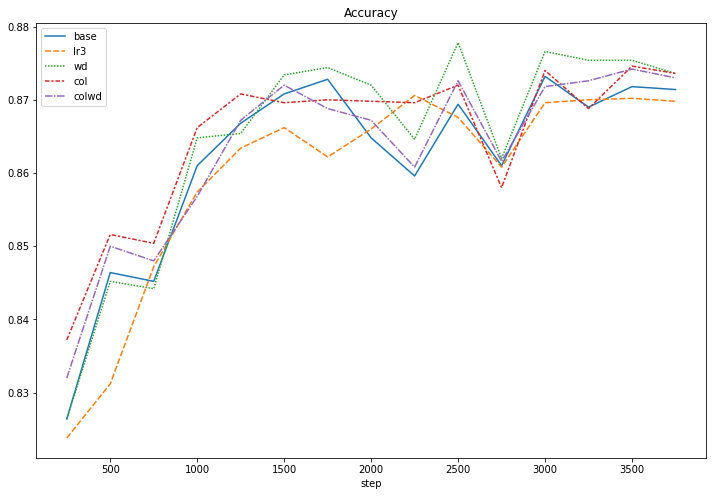

In [27]:
dfs = [base, lr3, wd, col, colwd]
accuracy_df = pd.concat([df['eval_accuracy'] for df in dfs], axis=1, keys=['base', 'lr3', 'wd', 'col', 'colwd'])

plt.figure(figsize=(12, 8))

ax = sns.lineplot(data=accuracy_df)
plt.title('Accuracy')
plt.show()

In [28]:
accuracy_df

,base,lr3,wd,col,colwd
step,,,,,
250,0.8264,0.8238,0.8264,0.8372,0.8320
500,0.8464,0.8312,0.8452,0.8516,0.8500
750,0.8452,0.8472,0.8442,0.8504,0.8480
1000,0.8610,0.8574,0.8648,0.8662,0.8568
1250,0.8668,0.8634,0.8654,0.8708,0.8672
1500,0.8708,0.8662,0.8734,0.8696,0.8720
1750,0.8728,0.8622,0.8744,0.8700,0.8688
2000,0.8648,0.8660,0.8720,0.8698,0.8672
2250,0.8596,0.8706,0.8646,0.8696,0.8608


🧐 10만건의 1/10 데이타인 1만건을 train 데이타를 기준으로 성능 검증을 했을 때 Wd(weight dacay), col(data collator), colwd( data collader + weight decay) 적용한 경우가 거의 비슷한 선능을 보였다. 
데이타셋의 수가 적어서 90%의 Accuracy까지는 도달하지 못한 것으로 보인다. 
전체적인 경향성을 보았을 때 `colwd( data collader + weight decay)`가 본데이타를 돌렸을 때 가장 좋은 성능을 보일 것으로 기대된다

### 6-2 F-1 Score 비교

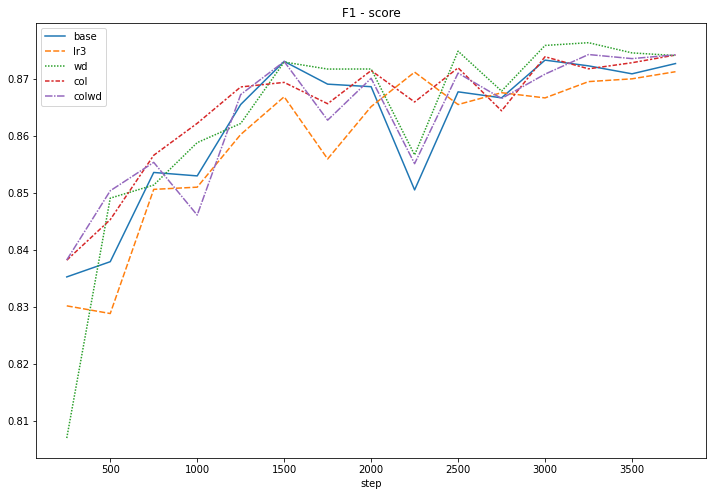

In [29]:
dfs = [base, lr3, wd, col, colwd]
f1_df = pd.concat([df['eval_f1'] for df in dfs], axis=1, keys=['base', 'lr3', 'wd', 'col', 'colwd'])

plt.figure(figsize=(12, 8))

ax = sns.lineplot(data=f1_df)
plt.title('F1 - score')
plt.show()


In [ ]:
🧐 F1-score의 경우도 Wd(weight dacay), col(data collator), colwd( data collader + weight decay) 3 지표가 모두 비슷한 추이를 보였다. 
추세가 좋았던 colwd를 모델로 채택하고 전체 데이타 훈련을 진행해 보았다. 

In [30]:
f1_df

,base,lr3,wd,col,colwd
step,,,,,
250,0.835232,0.830152,0.806940,0.838171,0.838213
500,0.837906,0.828803,0.849064,0.845288,0.850359
750,0.853575,0.850606,0.851364,0.856595,0.855348
1000,0.852972,0.850993,0.858814,0.862204,0.846088
1250,0.865509,0.860241,0.862175,0.868592,0.867253
1500,0.873084,0.866866,0.872968,0.869391,0.873066
1750,0.869082,0.855948,0.871732,0.865647,0.862762
2000,0.868636,0.865137,0.871743,0.871471,0.870110
2250,0.850511,0.871193,0.856659,0.865954,0.855121


🧐 Bucketing을 시도해 보았지만 reference가 부족해서 이걸 제대로 적용한 것인지 확인이 안된 상태에서 훈련을 시도했다. 
공식문서의 내용을 기반으로 작성했지만, 충분하게 숙지했는지 의문이다. 
전체적인 시간 차이도 그다지 확연한 차이를 느끼지 못했다. 성능과 시간과의 Trad-off 관계를 확인하고 싶었는데, 적용전이나 후나 일단 전체적인 선능은 크게 차이가 없어보인다. 

## Step 7  10만건 데이타  colwd( data collader + weight decay) 성능 검증

In [20]:
# 하이퍼파라미터 base   data_collator + wd
training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps = 500,
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.02,                        # weight decay
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    group_by_length=True,
    logging_steps=500
)

# DataCollatorWithPadding을 사용하여 bucketing 수행
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)    

# 학습 실행
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
#    callbacks=[early_stopping_callback]
)

trainer.train()        
history_colwb_total = pd.DataFrame(trainer.state.log_history)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 100000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Step,Training Loss,Validation Loss,Accuracy,F1
500,0.416700,0.365836,0.851420,0.849752
1000,0.357300,0.343098,0.862200,0.868516
1500,0.334500,0.295585,0.875580,0.870931
2000,0.313400,0.306150,0.873560,0.865615
2500,0.320200,0.293368,0.879600,0.878526
3000,0.306900,0.319653,0.881020,0.883529
3500,0.299200,0.298308,0.880180,0.883875
4000,0.303700,0.284025,0.887840,0.888977
4500,0.290400,0.277562,0.884160,0.887822
5000,0.281200,0.334516,0.889220,0.890566


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 16
Saving model checkpoint to ./transformers/checkpoint-500
Configuration saved in ./transformers/checkpoint-500/config.json
Model weights saved in ./transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 16
Saving model checkpoint to ./transformers/checkpoint-1000
Configuration saved in ./transformers/checkpoint-1000/config.json
Model weights saved in ./transformers/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have bee

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 16
Saving model checkpoint to ./transformers/checkpoint-10000
Configuration saved in ./transformers/checkpoint-10000/config.json
Model weights saved in ./transformers/checkpoint-10000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 16
Saving model checkpoint to ./transformers/checkpoint-10500
Configuration saved in ./transformers/checkpoint-10500/config.json
Model weights saved in ./transformers/checkpoint-10500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and

In [22]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 16


{'eval_loss': 0.3078936040401459,
 'eval_accuracy': 0.89594,
 'eval_f1': 0.8955619342018106,
 'eval_runtime': 796.1446,
 'eval_samples_per_second': 62.803,
 'eval_steps_per_second': 3.925,
 'epoch': 3.0}

🧐 Test Dataset 5만건을 대상으로 실행했을 때 Eval `Accuracy는 0.89594` 를 기록했다. 

In [21]:
history_colwb_total.to_csv('history_colwb_total.csv')

In [31]:
        
total_base = pd.read_csv('history_colwb_total.csv')
total_df = total_base[['step','loss','eval_loss', 'eval_accuracy','eval_f1']].groupby('step').sum()

In [32]:
total_df = total_df.reset_index()
total_df

,step,loss,eval_loss,eval_accuracy,eval_f1
0,500,0.4167,0.365836,0.85142,0.849752
1,1000,0.3573,0.343098,0.86220,0.868516
2,1500,0.3345,0.295585,0.87558,0.870931
3,2000,0.3134,0.306150,0.87356,0.865615
4,2500,0.3202,0.293368,0.87960,0.878526
5,3000,0.3069,0.319653,0.88102,0.883529
6,3500,0.2992,0.298308,0.88018,0.883875
7,4000,0.3037,0.284025,0.88784,0.888977
8,4500,0.2904,0.277562,0.88416,0.887822
9,5000,0.2812,0.334516,0.88922,0.890566


In [33]:
total_df = total_df[total_df['step'] != 18750] # 마지막 log기록을 못한 값 제거

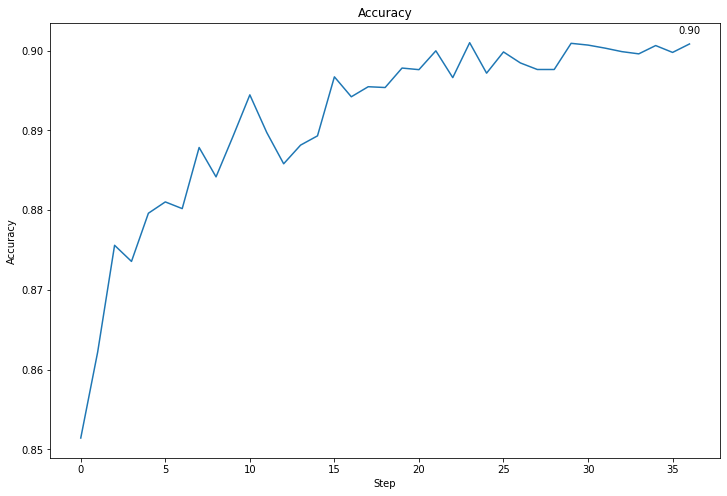

In [34]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=total_df['eval_accuracy'])
plt.title('Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
# 0.9를 넘는 마지막 값을 주석으로 표시
threshold = 0.9
last_index = total_df[total_df['eval_accuracy'] > threshold].index[-1]
last_acc = total_df.loc[last_index, 'eval_accuracy']
plt.annotate(f'{last_acc:.2f}', (last_index, last_acc), textcoords='offset points', xytext=(0,10), ha='center')

plt.show()

🧐 Train 중에 데이타를 보면 0.9이상을 기록한 경우가 몇몇 있었지만 0.91까지 올라가지는 못했다. 
Test dataset으로 평가했을 때는 다소 떨어진 0.98을 기록했다. 

# 회고

- 훈련시간이 정말 많이 걸린 프로젝트였다. 데이타 10만건이상으로 한번 Train하는데 10시간~12시간이 소요되는 상황에서 Finetunig을 진행해서 최적의 모델을 찾아야 했다. 그렇다면 모든 데이타를 모두 돌린다는 것은 시간상 불가능하고 다른 방법을 찾아야 했다. 
- 일단 적은 데이타 셋수를 줄여서 하이퍼파라미터를 조정하고, bucketing이라는 새로운 내용을 적용해 보는 것을 첫번째 목표로 했다. 
- 1만건( 전체 데이타의 1/10)을 대상으로 learning rate를 조정하고, weight dacay를 적용, data collator 적용 해서 각자 비교해 보았다. 
- 전체적으로 확연한 성능차이가 느껴지지는 않지만, 그래프 추세상 상승으로 마감하고, 전체적인 accuracy와 f1-score가 그래도 나은 모델 data collator와 weight dacay를 같이 적용한 모델을 채택했다. 
- 전체 10만건의 train데이타, 5만건 val data, 5만건 test데이타로 진행했고, 장장 11시간에 기다림 끝에 Accuracy 90%를 확인했다. 
- 전체 데이타에 대한 Base라인을 돌려보고 성능 튜닝과 비교해 보고 싶었지만 아쉽게도 제출시간에 맞추지 못할 듯 해서 그것은 못했다. 

- 만만치 않은 허들이 있는 프로제트였다. 사용해 보고 싶은 hugging face를 드디어 살펴볼 수 있어서 재미있었고, 
한번 훈련하는데도 장시간이 소요되는 인고가 필요하다는 깊은 인상을 남긴 프로젝트였다.    
- 트레이닝 결과 history 파일은 https://github.com/billygogo/Aiffel_GD_NLP/blob/main/data/GN-8history.zip 에 올려두었습니다.
<br>

- 이로서 Aiffel의 마지막 ex프로젝트를 마쳤다. 
- 지나온 exploration 돌아보았다. 
- ex를 처음 대했을 때 하나같이 막막함으로 시작했다. 
- 도대체 내가 이걸 어떻게 해낼 수 있을까. 과연 시간내에 제출을 할 수 있을까. 
- 그러면서 주섬주섬 Node에서 배웠던 것을 복습하고, 나도 모르게 내 주머니속에 있었던 개념과 기술set들을 꺼내며, 최근 사귄 절친 chatGPT와 이야기 나누며 한발한발 나갔던 시간들이었다. 
- 마침내 ex의 목표를 어느정도 달성했으면 더 찾아보고자 했다. 더 탐색하고, 남들과 다른 내가 볼 수 있는 것들이 무엇인지 찾으려 했다. 
- 재미있었고, 좋은 내용을 그루들과 함께 나눌 수 있어서 기뻤다. 
- 그리고 무엇보다. 내가 이런 걸 할 수 있다는 걸 볼 수 있어서 더 앞으로 나갈 수 있게 되어서 내가 많이 자랑스럽다.🚩
<br>
- 모든 날이 좋았다. ex가 어려운 날도, ex가 낯선 날도...   
- 좋은 컨텐츠와 좋은 퍼실님들과 신나게 여행했던 시간을 기록한다. 😉😂   
- 진환 퍼실님😉, 무성 퍼실님😁 그리고 강산 퍼실님😉 마음 깊이 감사를 보냅니다.    
- 2023년 6월 27일 마지막 ex를 마치며..   
